In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import yaml
import os
from datetime import datetime
import numpy as np
from utils import get_config2, resolve_path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Custom modules
from dataset3 import APOGEEDataset
from model2 import Generator
from tqdm import tqdm
from checkpoint import save_checkpoint, load_checkpoint

In [2]:
def initialize_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

In [8]:
def load_configurations():
    config = get_config2()
    
    dataset_name = config['dataset_name']
    dataset_config = config['datasets'][dataset_name]
    data_path = resolve_path(dataset_config['path'])
    checkpoints_path = resolve_path(config['paths']['checkpoints'])
    latent_path = resolve_path(config['paths']['latent'])
    plots_path = resolve_path(config['paths']['plots'])

    batch_size = config['training']['batch_size']
    num_workers = config['training']['num_workers']
    num_epochs = config['training']['num_epochs']
    learning_rate = config['training']['learning_rate']
    latent_learning_rate = config['training']['latent_learning_rate']
    latent_dim = config['training']['latent_dim']
    checkpoint_interval = config['training']['checkpoint_interval']

    return (config, data_path, checkpoints_path, latent_path, plots_path, 
            batch_size, num_workers, num_epochs, learning_rate, latent_learning_rate, latent_dim, checkpoint_interval)

In [10]:
print("initializing device ..")
device = initialize_device()
print("loading config..")
(config, data_path, checkpoints_path, latent_path, plots_path,
 batch_size, num_workers, num_epochs, learning_rate, latent_learning_rate, latent_dim, checkpoint_interval) = load_configurations()

initializing device ..
Using device: cpu
loading config..


In [24]:
def plot_real_vs_generated_batch(dataset, data_path, data_loader, generator, device, batch_index, plots_path):
    # Open the HDF5 file
    with h5py.File(data_path, 'r') as hdf5_file:

        # Find the specific batch
        batch = next((batch_data for i, batch_data in enumerate(data_loader) if i == batch_index), None)

        # Ensure the batch is found
        if batch is None:
            raise ValueError(f"Batch index {batch_index} not found in the data loader.")

        # Extract unique identifiers, real spectra, and masks from the batch
        unique_ids = batch['unique_id']
        real_spectra = batch['flux'].to(device)
        masks = batch['flux_mask'].to(device)

        # Generate the spectra using the generator model
        generator.eval()
        with torch.no_grad():
            latent_codes = [torch.tensor(hdf5_file[uid]['latent_code'][()]).to(device) for uid in unique_ids]
            latent_codes_tensor = torch.stack(latent_codes)
            generated_spectra = generator(latent_codes_tensor).cpu().numpy()

        # Plot real vs generated spectra for each item in the batch
        for i, uid in enumerate(unique_ids):
            real_spectrum = real_spectra[i].cpu().numpy()
            generated_spectrum = generated_spectra[i]
            mask = masks[i].cpu().numpy()

            # Calculate weighted MSE or another appropriate metric
            mse = np.mean((mask * (real_spectrum - generated_spectrum))**2) / np.mean(mask)

            plt.figure(figsize=(10, 5))
            plt.plot(real_spectrum, label='Real Spectrum', color='blue', alpha=0.7, linewidth=0.5)
            plt.plot(generated_spectrum, label='Generated Spectrum', color='red', alpha=0.7, linewidth=0.5)
            plt.title(f'Comparison of Real and Generated Spectra for {uid}\nMasked MSE: {mse:.4f}')
            plt.xlabel('Wavelength Index')
            plt.ylabel('Flux')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(plots_path, f'real_vs_generated_{uid}.png'))
            plt.show()
            plt.close()  



/arc/home/Amirabezine/deepSpectra/checkpoints/checkpoint_latest.pth.tar


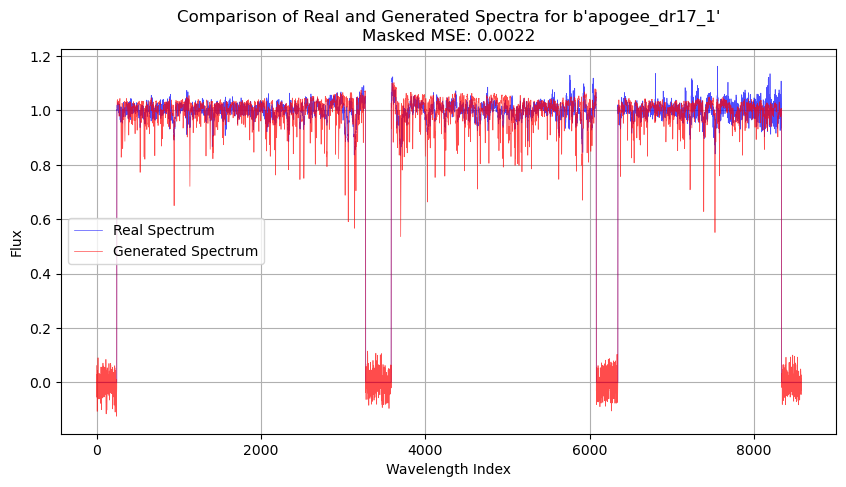

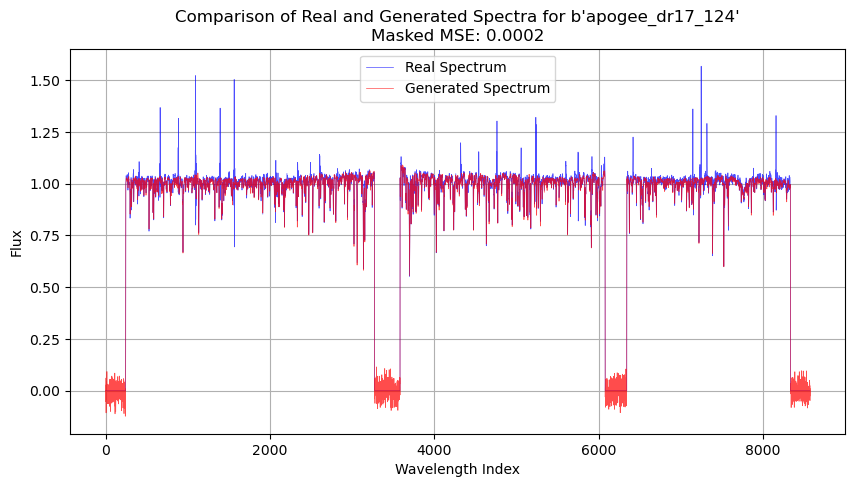

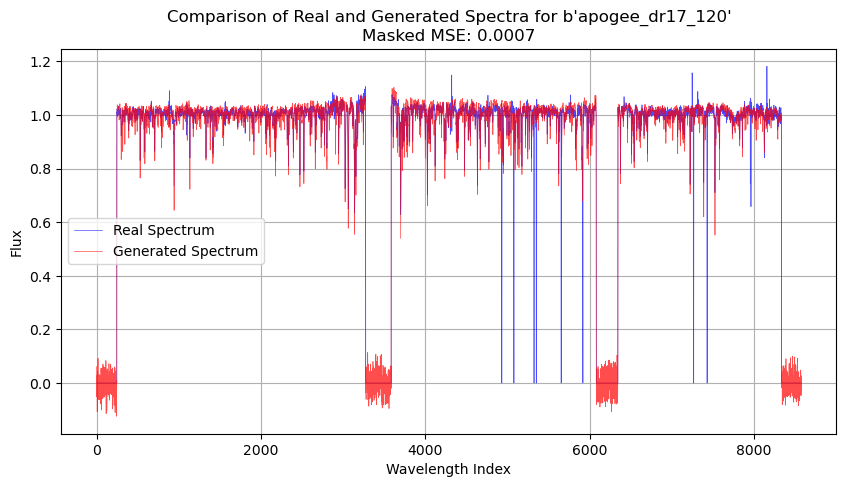

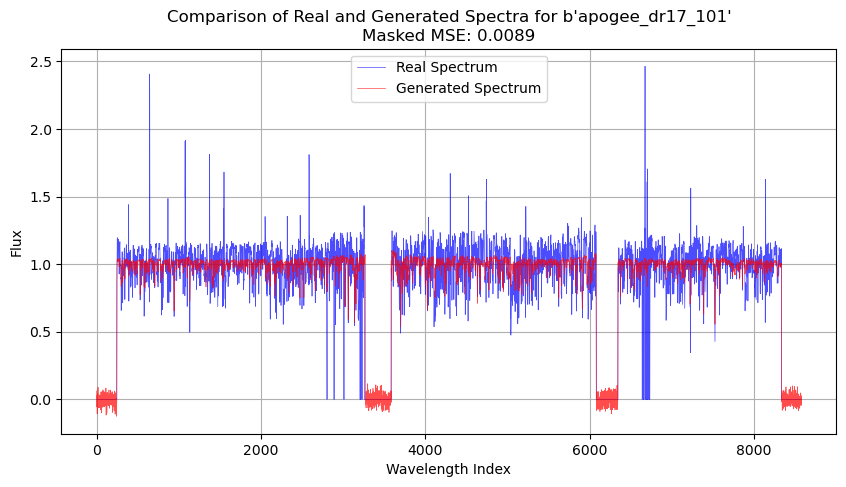

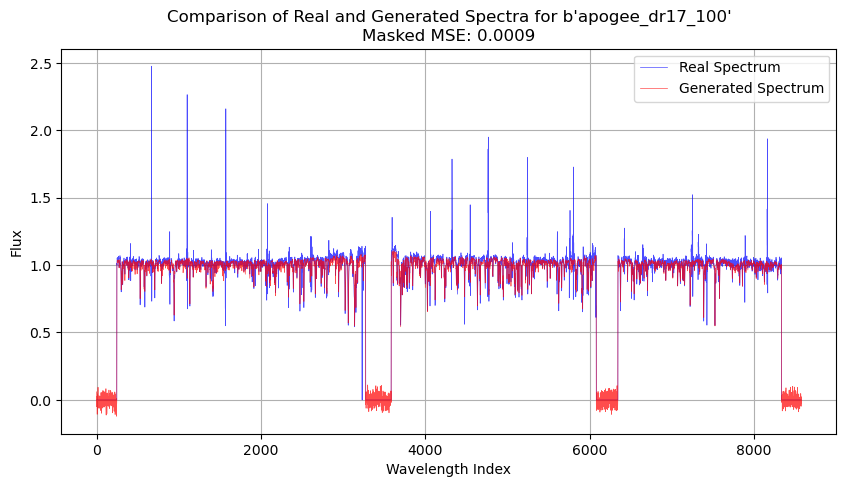

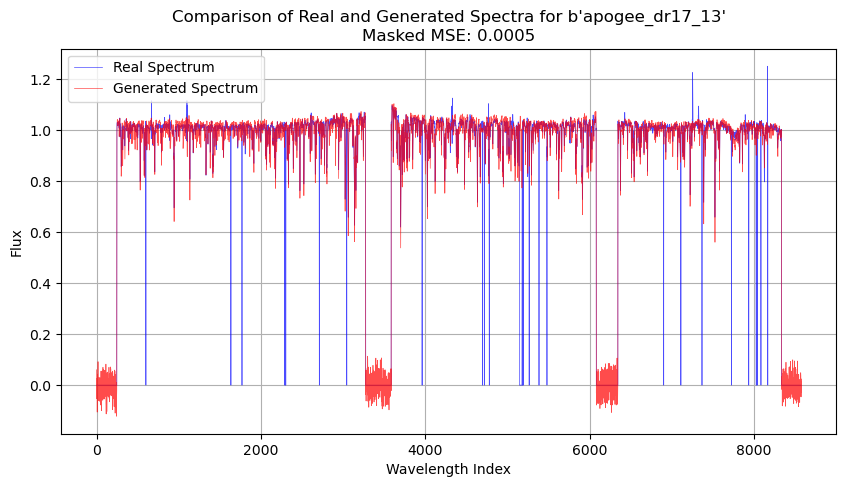

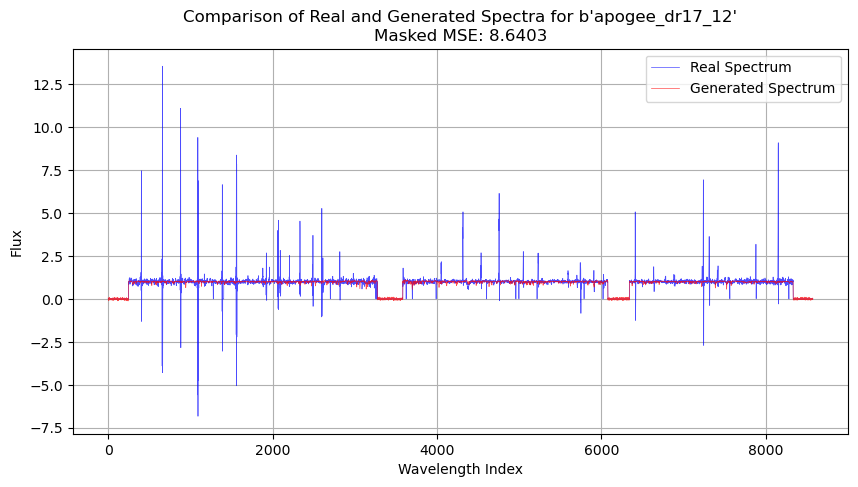

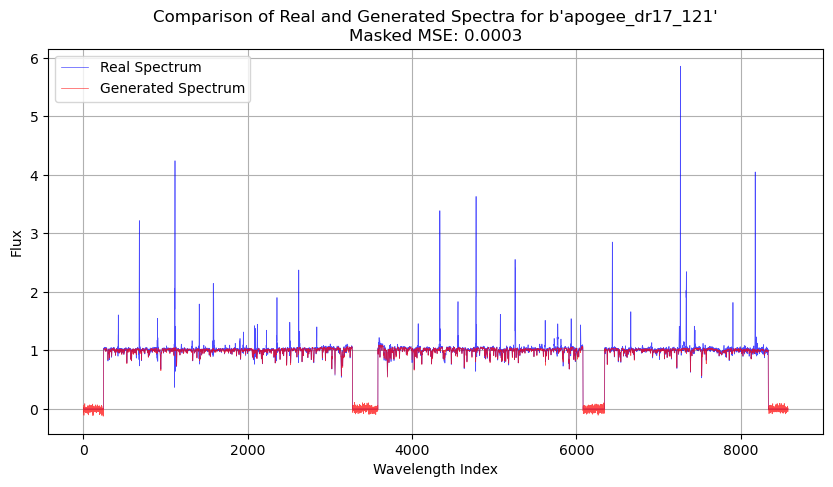

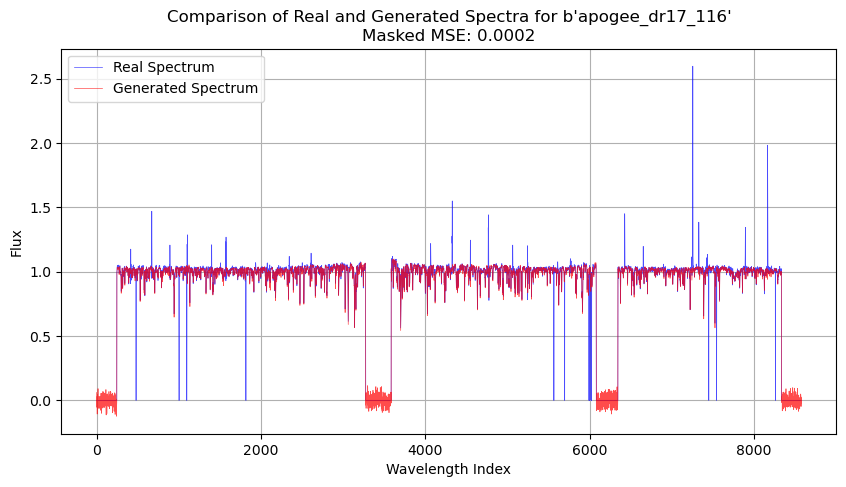

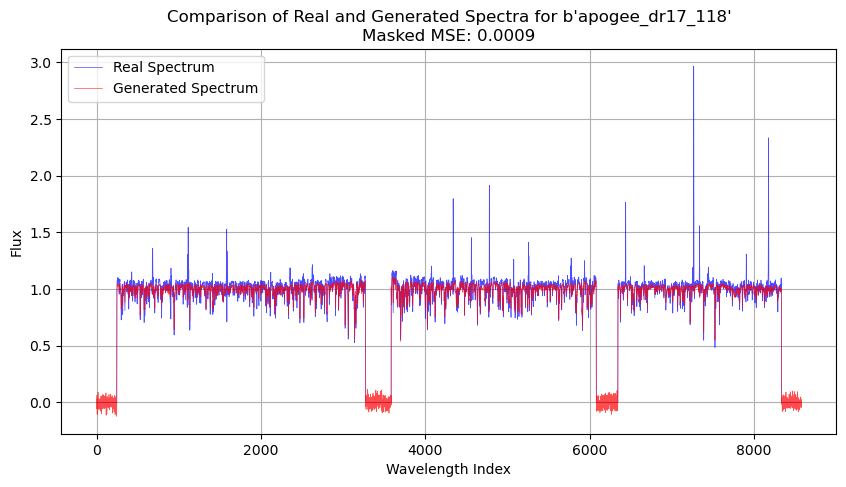

In [25]:

import h5py
# Initialize the dataset and data loader
dataset = APOGEEDataset(data_path, max_files=50)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Initialize the generator model
generator = Generator(config['training']['latent_dim'], config['model']['output_dim'], config['model']['generator_layers'], config['model']['activation_function']).to(device)

# Load the latest checkpoint if available
latest_checkpoint_path = os.path.join(checkpoints_path, 'checkpoint_latest.pth.tar')
print(latest_checkpoint_path)
if os.path.exists(latest_checkpoint_path):
    checkpoint = torch.load(latest_checkpoint_path)
    # print(checkpoint)
    generator.load_state_dict(checkpoint['generator_state_dict'])


# # Plot the real vs generated spectra for the batch of index batc_index
batch_index = 0
plot_real_vs_generated_batch(dataset, data_path, data_loader, generator, device, batch_index, plots_path)

In [26]:
def plot_latent_evolution(latent_dir, spectrum_index, num_epochs, plots_path):
    latent_evolution = []

    for epoch in range(1, num_epochs + 1):
        latent_path = os.path.join(latent_dir, f'latent_codes_epoch_{epoch}.npy')
        latent_data = np.load(latent_path, allow_pickle=True).item()
        latent_codes = latent_data['latent_codes']
        latent_evolution.append(latent_codes[spectrum_index])

    latent_evolution = np.array(latent_evolution)

    plt.figure(figsize=(12, 8))
    for i in range(latent_evolution.shape[1]):
        plt.plot(latent_evolution[:, i], label=f'Latent Dimension {i + 1}')

    plt.title(f'Evolution of Latent Space for Spectrum Index {spectrum_index}')
    plt.xlabel('Epoch')
    plt.ylabel('Latent Value')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plots_path, f'latent_evolution_{spectrum_index}.png'))
    plt.show()

In [27]:
plot_latent_evolution(latent_path, 118, num_epochs, plots_path)

FileNotFoundError: [Errno 2] No such file or directory: '/arc/home/Amirabezine/deepSpectra/latent/latent_codes_epoch_1.npy'